# NASA Earthdata Search and Discovery for PACE data
**Author:** Eli Holmes (NOAA)</br>
Last updated: November 6, 2025

[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/fish-pace/2025-tutorials/blob/main/pace_earthdata_access.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link] [![JupyterHub](https://img.shields.io/badge/Workshop_Hub-green?style=for-the-badge)][jupyter-link]

[download-link]: https://github.com/fish-pace/2025-tutorials/blob/main/pace_earthdata_access.ipynb
[colab-link]: https://colab.research.google.com/github/fish-pace/2025-tutorials/blob/main/pace_earthdata_access.ipynb
[jupyter-link]: https://workshop.nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/pace_earthdata_access.ipynb

>📘 Learning Objectives
>
> 1. How to authenticate with `earthaccess.login()`
> 2. How to use `earthaccess.search_data()` to search for data using spatial and temporal filters
> 3. How to explore and work with search results
> 4. Use `xarray.open_dataset()` to load Level 3 data
> 6. Use xarray to load Level 2 data
> 7. (Optional) Plotting and managing memory.


## Summary

In this example we will use the `earthaccess` library to search for data collections from NASA Earthdata. `earthaccess` is a Python library that simplifies data discovery and access to NASA Earth science data by providing an abstraction layer for NASA’s [Common Metadata Repository (CMR) API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html) Search API. The library makes searching for data more approachable by using a simpler notation instead of low level HTTP queries. `earthaccess` takes the trouble out of Earthdata Login **authentication**, makes **search** easier, and provides a stream-line way to download or stream search results into an `xarray` object.

For more on `earthaccess` visit the [`earthaccess` GitHub](https://github.com/nsidc/earthaccess) page and/or the [`earthaccess` documentation](https://earthaccess.readthedocs.io/en/latest/) site. Be aware that `earthaccess` is under active development. 

## Prerequisites

An Earthdata Login account is required to access data from NASA Earthdata. Please visit <https://urs.earthdata.nasa.gov> to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.  


## Get Started

### Import Required Packages  

In [1]:
import earthaccess
import xarray as xr

### Authenticate to NASA Earthdata

`persist=True` will cause a `.netrc` file to be added to your home directory with your Earthdata login information.

In [2]:
auth = earthaccess.login(persist=True)

### Search for data  `earthaccess.search_data()` 

We want to search NASA Earthdata for collections using the OCI instrument. Use
<https://search.earthdata.nasa.gov/search?fi=OCI>

There are multiple keywords we can use to discovery data from collections. We are going to focus on  `short_name` here, but you can also use `concept_id`, and `doi`. 

### Search by sensor

In [4]:
results = earthaccess.search_datasets(instrument="oci")
for item in results[1:20]:
    summary = item.summary()
    print(summary["short-name"])

PACE_OCI_L2_AER_UAA
PACE_OCI_L2_AOP
PACE_OCI_L2_AOP_NRT
PACE_OCI_L2_BGC_NRT
PACE_OCI_L3M_CHL
PACE_OCI_L3M_CHL_NRT
PACE_OCI_L2_BGC
PACE_OCI_L2_CLOUD
PACE_OCI_L2_CLOUD_MASK
PACE_OCI_L2_CLOUD_NRT
PACE_OCI_L2_SFREFL_NRT
PACE_OCI_L2_UVAI_UAA_NRT
PACE_OCI_L3M_AER_UAA_NRT
PACE_OCI_L4M_MOANA
PACE_OCI_L1C_SCI
PACE_OCI_L2_AER_UAA_NRT
PACE_OCI_L2_CLOUD_MASK_NRT
PACE_OCI_L2_IOP
PACE_OCI_L2_IOP_NRT


### Search by short name - Level 2 data `L2`

Let's look at Level 2 Apparent Optical Properties. Short name `PACE_OCI_L2_AOP`. Rrs is in this group of variables.


In [3]:
# Level 2 data
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L2_AOP',
    temporal = ("2025-03-05", "2025-03-05")
)
len(results)

143

Why are there so many?? Level 2 data is swath data not a global grid. What is a "swath"? It is a fixed width region (in the case of the ocean color sensor, it is 2,500km wide) following the path of the satellite over the earth. For swath data (level 2), we need to specify a bounding box so we only get the swath(s) over our region of interest. Here we specify a bounding box for the U.S. Great Lakes.

In [33]:
# Level 2 data
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L2_AOP',
    temporal = ("2025-03-05", "2025-03-05"),
    bounding_box = (-90.0, 40.0, -75.0, 47.0)
)
len(results)

3

### Search by short name - Level 3 mapped data `L3M`

The Level 3 mapped data is global data on a grid (no swaths and no tiles) so there should be one file per day, right?

In [34]:
# Level 3 data
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_RRS',
    temporal = ("2025-03-05", "2025-03-05")
)
len(results)

8

Why so many? There are month, 8-day, day and 2 resolutions. You need to look at the filenames and filter to get the files you want. We have to filter/select files with a specific format using `granule_name`.

In [6]:
# all the file names
[res.data_links() for res in results]

[['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20241221_20250320.L3m.SNWI.RRS.V3_1.Rrs.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20241221_20250320.L3m.SNWI.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250226_20250305.L3m.8D.RRS.V3_1.Rrs.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250226_20250305.L3m.8D.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250301_20250331.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250301_20250331.L3m.MO.RRS.V3_1.Rrs.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250305.L3m.DAY.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250305.L3m.DAY.RRS.V3_1.Rrs.4k

In [7]:
# Level 3 data
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_RRS',
    temporal = ("2025-03-05", "2025-03-05"),
    granule_name="*.MO.*.0p1deg.*"
)
len(results)

1

### Refining the search

Here are the common arguments for `earthaccess.search_data()`:

* `bounding_box` is a lat/lon box, e.g. `(xmin=-73.5, ymin=33.5, xmax=-43.5, ymax=43.5)`
* `temporal` is a date range, e.g. `("2020-01-16", "2020-12-16")`
* `cloud_cover` is a range `(0, 10)`
* `granule_name` is a matching filter, e.g. `"*.DAY.*.0p1deg.*"`
* `short_name` or `collection_id`

### Summary

* `earthaccess.login()` to authenticate
* `earthaccess.search_data()` to find the data files. This gives an object with all the info needed to get the data.


## Working with `earthaccess` searches

Following the search for data, you'll likely take one of two pathways with those results. You may choose to **download** the assets that have been returned to you or you may choose to continue working with the search results within the Python environment.  

#### What are the granules (files)

In [37]:
# Level 3 data (global)
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_RRS',
    temporal = ("2025-03-01", "2025-03-01"),
    granule_name="*.MO.*.0p1deg.*"
)
len(results)

1

In [26]:
type(results[0])

earthaccess.results.DataGranule

In [27]:
results[0]

Collection: {'ShortName': 'PACE_OCI_L3M_RRS', 'Version': '3.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'NorthBoundingCoordinate': 90, 'EastBoundingCoordinate': 180, 'SouthBoundingCoordinate': -90, 'WestBoundingCoordinate': -180}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-03-05T00:00:00Z', 'EndingDateTime': '2024-03-31T23:59:59Z'}}
Size(MB): 586.9740610122681
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240301_20240331.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc']

#### Download `earthaccess` results

In some cases you may want to download your assets. `earthaccess` makes downloading the data from the search results very easy using the `earthaccess.download()` function. 

`earthaccess` does a lot of heavy lifting for us. It identifies the downloadable links, passes our Earthdata Login credentials, and saves the files with the proper names.

#### Work in the cloud

Alternatively we can work with the metadata without downloading and only load the data into memory (or download) when we need to compute with it or plot it. 

We use `earthaccess`'s `open()` method to create a 'fileset' to the cloud objects and then open that with `xarray`.

In [28]:
# Step 1 create a fileset
fileset = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/12 [00:00<?, ?it/s]

We can load the information about the data and look at its properties without actually loading all the data into memory. Here we load one file using `fileset[0]`.

In [32]:
# Step 2 open with xarray
ds = xr.open_dataset(fileset[0], chunks={})
ds

<xarray.Dataset> Size: 4GB
Dimensions:     (wavelength: 172, lat: 1800, lon: 3600, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 4GB dask.array<chunksize=(16, 1024, 8), meta=np.ndarray>
    palette     (rgb, eightbitcolor) uint8 768B dask.array<chunksize=(3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240301_20240331.L3m.MO.RRS....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3315440
    data_minimum:                      -0.009997999
    data_maximum:                      0.09494999

Not loading all the data into memory is important since it is large.

In [33]:
ds_size_gb = ds.nbytes / 1e9
print(f"Dataset size: {ds_size_gb:.2f} GB")

Dataset size: 4.46 GB


### Summary

* `earthaccess.download()` to download results.
* `earthaccess.open()` to create an object (fileset or path) for working with data in the cloud.

## Level 3 mapped data `L3M`

Level 3 data is on a global lat/lon grid. The short name will have `L3M` in it. The resolution (width/height) of the grids is either 4km or 0.1 degrees. 

Let's load a year of data.

#### Step 1. Search for the data

In [38]:
# Level 3 data (global)
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_RRS',
    temporal = ("2024-03-01", "2025-02-01"),
    granule_name="*.MO.*.0p1deg.*"
)
len(results)

12

In [5]:
# look at the file names to make sure they are ok
[res.data_links() for res in results]

[['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240301_20240331.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240401_20240430.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240501_20240531.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240601_20240630.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240701_20240731.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240801_20240831.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240901_20240930.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20241001_20241031.L

#### Step 2. Set up the fileset

This step is needed so that `xarray` knows how to interact with the data in the cloud bucket.

In [39]:
fileset = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/12 [00:00<?, ?it/s]

#### Step 3. Open the fileset with xarray

Open one file using `open_dataset()`. Open all 12 files with `open_mfdataset()` and since the netcdf files do not have a time coordinate (just lat, lon, wavelength), we need to tell xarray to combine on a new dimension "time".

##### Open one file

Notice the coordinates (lat/lon and wavelength) and the data variables (Rrs).

In [16]:
ds1 = xr.open_dataset(fileset[1])
ds1

<xarray.Dataset> Size: 4GB
Dimensions:     (wavelength: 172, lat: 1800, lon: 3600, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 4GB ...
    palette     (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240401_20240430.L3m.MO.RRS....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3355114
    data_minimum:                      -0.009991998
    data_maximum:                      0.099733464

We can plot this object. But let's not plot the full global data as that is 4+ Gb. We will plot a subset using the `slice()` function. This way we only load the data needed to plot into memory. We need to 
* pick the variable. Let's use `Rrs`
* pick a wavelength
* slice to a smaller lat/lon

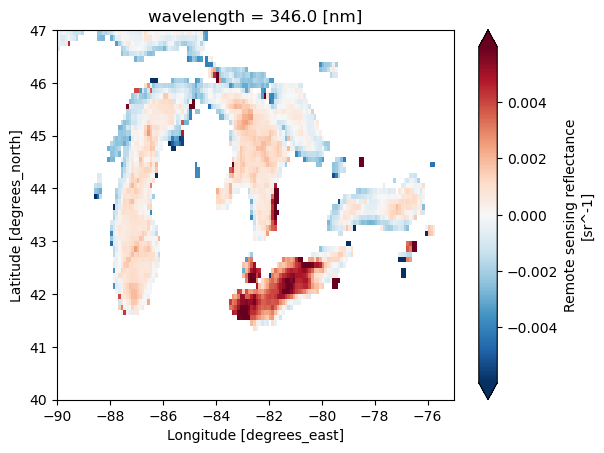

In [21]:
# Plot
rrs = ds1['Rrs'].sel(
    wavelength=346, 
    lat=slice(47, 40), 
    lon=slice(-90, -75))
rrs.plot(robust=True);

#### Optional. Open all 12 months and make a plot

Click on 3 dots to expand the code.

In [40]:
# We can open all the files but note there is no time coordinate so we need
# combine="nested" and concat_dim
ds = xr.open_mfdataset(
    fileset,
    combine="nested",
    concat_dim="time")
ds

<xarray.Dataset> Size: 53GB
Dimensions:     (time: 12, lat: 1800, lon: 3600, wavelength: 172, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: time, rgb, eightbitcolor
Data variables:
    Rrs         (time, lat, lon, wavelength) float32 53GB dask.array<chunksize=(1, 16, 1024, 8), meta=np.ndarray>
    palette     (time, rgb, eightbitcolor) uint8 9kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240301_20240331.L3m.MO.RRS....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3315440
    data_minimum:                      -0.009997999
    data_maximum:                      0.09494999

In [11]:
# Let's add the time coord since we will likely want to subset on time later
import pandas as pd
t = pd.date_range(start="2024-03-01", end="2025-02-01", freq="MS")
ds = ds.assign_coords(time=t)
ds

<xarray.Dataset> Size: 53GB
Dimensions:     (time: 12, lat: 1800, lon: 3600, wavelength: 172, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * time        (time) datetime64[ns] 96B 2024-03-01 2024-04-01 ... 2025-02-01
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (time, lat, lon, wavelength) float32 53GB dask.array<chunksize=(1, 16, 1024, 8), meta=np.ndarray>
    palette     (time, rgb, eightbitcolor) uint8 9kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240301_20240331.L3m.MO.RRS....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3315440
    data_minimum:                      -0.009997999
    data_maximum:                      0.09494999

Let's plot all the months and fix the warping of space by adding a lat/lon projection, aka tell the plotting that this is lat/lon on a globe.

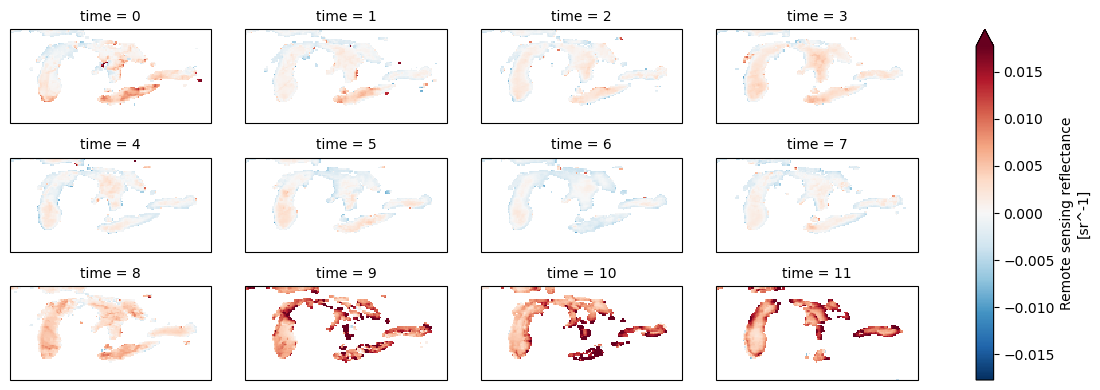

In [41]:
rrs = ds["Rrs"].sel(
    wavelength=346,
    lat=slice(47, 40),
    lon=slice(-90, -75)
)

rrs.plot(
    col="time",            # one panel per month
    col_wrap=4,            # 4 columns per row
    robust=True,           # ignore outliers for color scale
    figsize=(12, 4),
    subplot_kws={"projection": ccrs.PlateCarree()},
    transform=ccrs.PlateCarree()
)

### Summary

For Level 3, we use the mapped data product, `L3M` and the steps to open with xarray are
* `res=earthaccess.search_data()` with `granule_name` to filter to the temporal binning (day, 8-day, month) and resolution (4km or 0.1 degree). We do not need `bounding_box` since level 3 is global.
* `fileset=earthaccess.open(res)`
* `ds=xarray.open_dataset(fileset[i])` to open the i-th file in the fileset or `ds=xarray.open_mfdataset(fileset)` to open multiple datasets.

## Level 2 data

Level 2 data is not on a global lat/lon grid. Instead each swath (satelite path) has "lines" along the path and "pixels" across the lines (perpendicular to path).  In addition, the data files are GROUPED netcdfs (different format). We need to open these with `open_datatree` and then merge all the groups. 

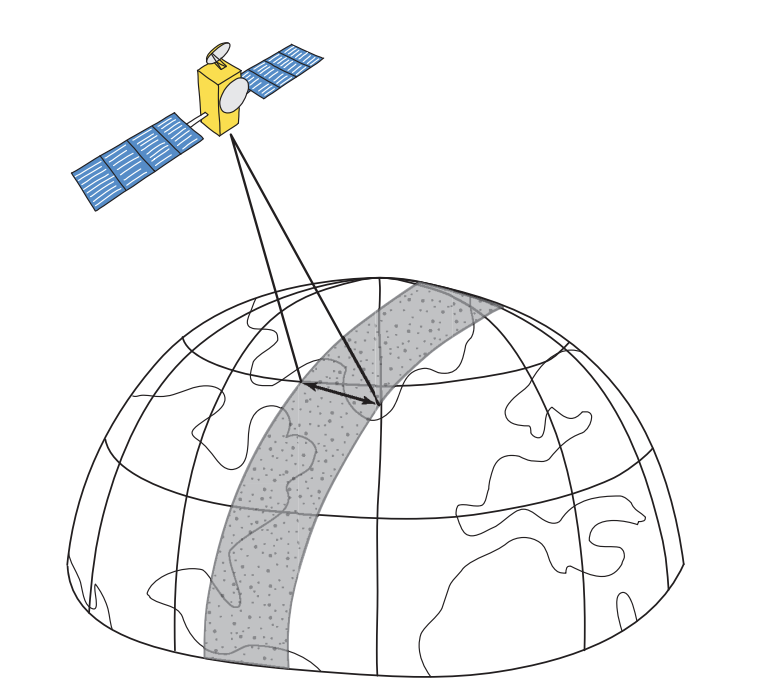

Let's get the swath(s) over the U.S. Great Lakes on March 5th, 2025.

In [3]:
import xarray as xr
import earthaccess
auth = earthaccess.login(persist=True)
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L2_AOP',
    temporal = ("2024-03-05", "2024-03-05"),
    bounding_box = (-90.0, 40.0, -75.0, 47.0)
)
len(results)

2

In [4]:
# Step 1 set up the fileset
fileset = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# Step 2 open ONE file with xarray open_datatree
datatree = xr.open_datatree(fileset[1])
datatree.groups

/tmp/ipykernel_2230/57882665.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  datatree = xr.open_datatree(fileset[1])


('/',
 '/sensor_band_parameters',
 '/scan_line_attributes',
 '/geophysical_data',
 '/navigation_data',
 '/processing_control',
 '/processing_control/input_parameters',
 '/processing_control/flag_percentages')

The geophysical data is the data like Rrs and the navigation data has the lat/lon information for each line/pixel.

In [6]:
# Step 3 merge the groups all together.
# This works due to the values in each group being the same shape.
ds_l2 = xr.merge(datatree.to_dict().values())
ds_l2 = ds_l2.set_coords(("longitude", "latitude"))
ds_l2

<xarray.Dataset> Size: 3GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 172, number_of_lines: 1709,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 1kB 346.0 348.0 351.0 ... 717.0 719.0
    longitude      (number_of_lines, pixels_per_line) float32 9MB ...
    latitude       (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/30)
    wavelength     (number_of_bands) float64 2kB ...
    vcal_gain      (number_of_reflective_bands) float32 1kB ...
    vcal_offset    (number_of_reflective_bands) float32 1kB ...
    F0             (number_of_reflective_bands) float32 1kB ...
    aw             (number_of_reflective_bands) float32 1kB ...
    bbw            (number_of_reflective_bands) float32 1kB ...
    ...             ...
    aot_865        (number_of_lines, pixels_per_line) float32 9MB ...
    angstrom       (number_of_lines, pixels_per_line) float32 9MB ...
    avw            (number_of_lines, pixels_per_line) float32 9MB ...
    nflh           (number_of_lines, pixels_per_line) float32 9MB ...
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB ...
    tilt           (number_of_lines) float32 7kB ...
Attributes: (12/47)
    title:                             OCI Level-2 Data AOP
    product_name:                      PACE_OCI.20240305T181043.L2.OC_AOP.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data3/sdpsoper/vdc/vpu2/wor...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                -108.4052
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     1.016156792640686
    geospatial_bounds:                 POLYGON ((-69.35211 55.80880, -108.405...

Let's plot. Hmm it's mainly blank. This is in March and is daily data. There were lots of clouds that day.
* Specify the variable `Rrs` in `[ ]`
* Spefify the wavelength, a coordinate, using `.sel()`
* Plot and tell it to use longitude for x and latitude for y.

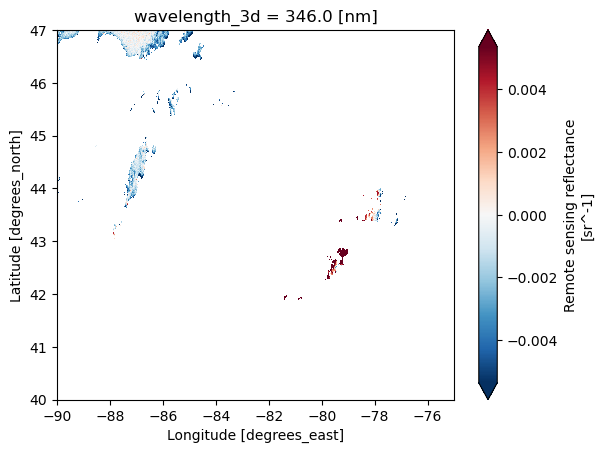

In [36]:
# Plot
rrs = ds_l2['Rrs'].sel(
    wavelength_3d=346)
rrs.plot(robust=True, 
         x="longitude", y="latitude",
         xlim=(-90, -75), ylim=(40, 47));

### Optional. Plot with the outline of the Great Lakes

Click on dots to open the code.

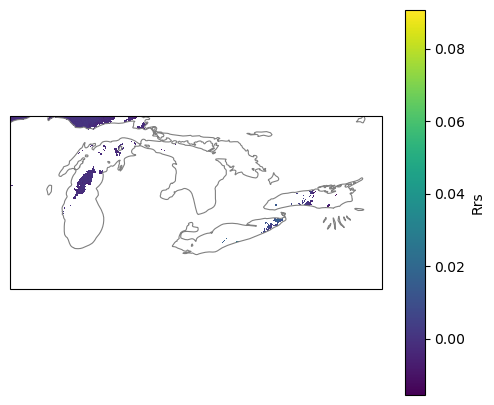

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(6,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-90, -75, 40, 47], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAKES.with_scale("50m"),
               facecolor="none", edgecolor="grey", linewidth=0.8)

# swath pieces
da  = ds_l2["Rrs"].sel(wavelength_3d=346)     # (lines, pixels)
lat = ds_l2["latitude"]
lon = ds_l2["longitude"]

# add to your existing ax (before plt.show)
im = ax.pcolormesh(
    lon, lat, da,
    transform=ccrs.PlateCarree(),
    shading="nearest",      # lighter than 'auto'
    rasterized=True
)
plt.colorbar(im, ax=ax, label="Rrs")

plt.show()



### Summary

With level 2 data, we need to use `xarray.open_datatree()` and then do a `merge` step to get all the variables in the groups. Note we can only work with one level 2 dataset at a time.
* `res=earthaccess.search_data()` with `bounding_box` to filter to the region of interest.
* `fileset=earthaccess.open(res)`
* `datatree=xarray.open_datatree(fileset[i])` to open the i-th file in the fileset.
* `ds=xarray.merge(datatree.to_dict().values())` to merge all the groups
* `ds = ds.set_coords(("longitude", "latitude"))` to make longitude and latitude coords (will help with plotting.


## Working with larger than memory data

Here are a few basics to know when working with larger-than memory data.

### Chunks

The PACE data are cloud-optimized (read optimized) so that we don't have to read the whole file into memory to work with it and we don't have to download the whole thing if we don't need to.

In [14]:
ds.chunks

Frozen({'lat': (16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8), 'lon': (1024, 1024, 1024, 528), 'wavelength': (8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4), 'rgb': (3,), 'eightbitcolor': (256,)})

Chunking let's us work with big datasets without blowing up our memory. This task takes awhile but it doesn't blow up our little 2Gb RAM virtual machines. `xarray` and `dask` are smart and work through the task chunk by chunk.

In [15]:
%%time
# Pick a variable and a wavelength value
varname = list(ds.data_vars)[0]
# select the first wavelength
one_wl = ds[varname].isel(wavelength=0)
# under the hood, dask + xarray is computing the mean chunk by chunk
val = one_wl.mean(dim=("lat", "lon")).compute()

CPU times: user 26.2 s, sys: 11.5 s, total: 37.8 s
Wall time: 1min 46s


If we tried to load the data into memory, we would crash our kernel (max out the RAM).

In [ ]:
%%time
# THIS WILL CRASH THE KERNEL
# this tries to load the whole dataset all at once into memory
unchunked_slice = one_wl.load()
# this would be fast if the load step didn't crash the memory 
val = unchunked_slice.mean(dim=("lat", "lon"))

## Summary

This concludes the `earthaccess` tutorial for PACE data. 
* Opening Level 3 netcdfs with xarray
* Opening Level 2 netcdfs with xarray and datatree
* Working with larger than memory data.
